In [72]:
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import glob
from torch.utils.data import Dataset
import os
import numpy as np
from sklearn.cluster import KMeans
import json
import torch
import random
import cv2


class SatelliteToMapDataset(Dataset):
    def __init__(self, root_dir, n_colors=10, resize=None, augmentation=True, plot=False, output_type='map', n_samples_per_image=5000, load=True, erosion_size=3, dilation_size=3):
        self.root_dir = root_dir
        self.n_colors = n_colors
        self.erosion_size = erosion_size
        self.dilation_size = dilation_size
        self.load = load
        self.n_samples_per_image = n_samples_per_image
        self.output_type = output_type
        self.color_centers = self.get_color_centers()
        self.file_list = glob.glob(self.root_dir + '/*.jpg')
        self.transform = self.get_transforms(resize, augmentation)
        self.transform_mask = self.get_transforms_mask(resize, augmentation)
        self.plot = plot
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(self.file_list[idx])
        w, h = img.size
        
        img_A, img_B, img_masks = self.transform_set(img.crop((0, 0, w / 2, h)), img.crop((w / 2, 0, w, h)), random.randint(0, 2**32))
        
        if self.plot:
            self.plot_image_pair(img_A, img_B, img_masks)

        if self.output_type == 'map':
            return {'satellite_image': img_A, 'map_image': img_B}
        
        return {'satellite_image': img_A, 'masks_image': img_masks}
    
    def transform_set(self, img_A, img_B, seed):
        
        masks = self.create_masks_from_image(img_B, self.color_centers) if self.output_type == 'mask' else []
        transformed_masks = []
        
        random.seed(seed)
        torch.manual_seed(seed)

        img_A = self.transform(img_A)
        
        random.seed(seed)
        torch.manual_seed(seed)

        img_B = self.transform(img_B)
        
        for mask in masks:
            random.seed(seed)
            torch.manual_seed(seed)

            transformed_masks.append(self.transform_mask(mask))
            
        if self.output_type == 'mask':
            transformed_masks = np.stack([self.clean_mask(mask) for mask in transformed_masks], axis=0)
            transformed_masks = torch.from_numpy(transformed_masks).float()

        return img_A, img_B, transformed_masks
    
    def clean_mask(self, mask):
        kernel_erode = np.ones((self.erosion_size, self.erosion_size), np.uint8)
        kernel_dilate = np.ones((self.dilation_size, self.dilation_size), np.uint8)

        # Convert torch tensor to numpy if necessary
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()
            
        if mask.ndim == 3 and mask.shape[0] == 1:  # for single-channel 3D tensor
            mask = mask.squeeze(0)  # remove channel dimension
            
        mask = mask.astype(np.uint8)

        if self.erosion_size > 0:
            mask = cv2.erode(mask, kernel_erode, iterations=1)
        if self.dilation_size > 0:
            mask = cv2.dilate(mask, kernel_dilate, iterations=1)

        return mask
    
    def get_transforms(self, resize=None, augmentation=True):
        transform_list = []

        if resize is not None:
            transform_list.append(transforms.Resize(resize))

        transform_list.append(transforms.ToTensor())

        if augmentation:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(30),
                transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
                transforms.RandomPerspective(distortion_scale=0.1, p=0.4),
                transforms.RandomErasing(p=0.4, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
            ])

        transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

        return transforms.Compose(transform_list)
    
    def get_transforms_mask(self, resize=None, augmentation=True):
        transform_list = []

        if resize is not None:
            transform_list.append(transforms.Resize(resize))

        transform_list.append(transforms.ToTensor())

        if augmentation:
            transform_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(30),
                transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
                transforms.RandomPerspective(distortion_scale=0.1, p=0.4),
                transforms.RandomErasing(p=0.4, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
            ])

        return transforms.Compose(transform_list)
    
    def plot_image_pair(self, satellite_image, map_image, masks):
        # Convert the images back to PIL for display if they are tensors
        if isinstance(satellite_image, torch.Tensor):
            satellite_image = transforms.ToPILImage()(satellite_image)
        if isinstance(map_image, torch.Tensor):
            map_image = transforms.ToPILImage()(map_image)

        # Determine the number of rows required for subplots based on the number of masks
        num_masks = len(masks)
        num_rows = (num_masks + 2 + 1) // 2  # 2 images (satellite, map) and masks

        # Plotting
        fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
        
        if num_rows > 1:
            axs[0, 0].imshow(satellite_image)
            axs[0, 0].set_title("Satellite Image")
            axs[0, 0].axis('off')

            axs[0, 1].imshow(map_image)
            axs[0, 1].set_title("Map Image")
            axs[0, 1].axis('off')
        else:
            axs[0].imshow(satellite_image)
            axs[0].set_title("Satellite Image")
            axs[0].axis('off')

            axs[1].imshow(map_image)
            axs[1].set_title("Map Image")
            axs[1].axis('off')

        # Plot each mask
        for i, mask in enumerate(masks):
            row = (i + 2) // 2
            col = (i + 2) % 2
            
            if mask.ndim == 3 and mask.shape[0] == 1:
                mask = mask.squeeze(0)  # Remove the channel dimension

            axs[row, col].imshow(mask, cmap='gray')
            axs[row, col].set_title(f"Mask {i + 1}")
            axs[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    def find_representative_colors(self):
        # Initialize an empty array for storing sampled pixels
        sample_pixels = np.empty((0, 3), dtype=int)

        for img_name in os.listdir(self.root_dir):
            img = Image.open(os.path.join(self.root_dir, img_name))
            
            w, h = img.size
            img = img.crop((w // 2, 0, w, h))  # Crop the right half of the image

            # Convert to NumPy array
            np_img = np.array(img)

            # Randomly sample pixels from the image
            idx = np.random.choice(np_img.shape[0] * np_img.shape[1], self.n_samples_per_image, replace=False)
            sampled_pixels = np_img.reshape(-1, 3)[idx]

            # Append sampled pixels to the array
            sample_pixels = np.vstack((sample_pixels, sampled_pixels))

        # Apply KMeans to find color centers
        # Explicitly setting n_init to 'auto' to suppress the warning and future-proof the code
        kmeans = KMeans(n_clusters=self.n_colors, random_state=0, n_init='auto').fit(sample_pixels)
        return kmeans.cluster_centers_
    
    def create_masks_from_image(self, image, color_centers):
        # Convert PIL Image to NumPy array
        np_image = np.array(image)
        # Reshape image and assign each pixel to the nearest color center
        pixels = np_image.reshape(-1, 3)
        
        nearest_centers = np.argmin(np.linalg.norm(pixels - color_centers[:, np.newaxis], axis=2), axis=0)
        clustered_image = color_centers[nearest_centers].reshape(np_image.shape).astype(np.uint8)

        # Split masks into binary masks for each color center
        masks = nearest_centers.reshape(np_image.shape[:2])
        binary_masks = [(masks == i).astype(int) for i in range(len(color_centers))]
        
        return binary_masks
    
    def visualize_color_centers(self, color_centers):
        # Create a figure and a set of subplots
        fig, ax = plt.subplots()

        # Add a rectangle patch for each color
        for i, color in enumerate(color_centers):
            # Normalize color values to [0, 1] as expected by matplotlib
            color_normalized = color / 255.0
            rect = patches.Rectangle((i, 0), 1, 1, linewidth=1, edgecolor='r', facecolor=color_normalized)
            ax.add_patch(rect)

        # Set the limits and aspect of the plot
        ax.set_xlim(0, self.n_colors)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal', adjustable='box')
        plt.axis('off')  # Turn off the axis

        plt.savefig("models/color_centers.png")
        
    def get_color_centers(self):
        try:
            assert self.load == True
            with open("models/segmentation_thresholds.json", "r") as f:
                color_centers = json.load(f)
            assert len(color_centers) == self.n_colors
        except:
            color_centers = self.find_representative_colors()
            self.visualize_color_centers(color_centers)
            
            with open("models/segmentation_thresholds.json", "w") as f:
                json.dump(color_centers.tolist(), f)
            
        return np.array(color_centers)

In [77]:
dataset = SatelliteToMapDataset("data/train_0", erosion_size=1, dilation_size=1, plot=True, output_type='mask', n_samples_per_image=100000, n_colors=9, load=True)

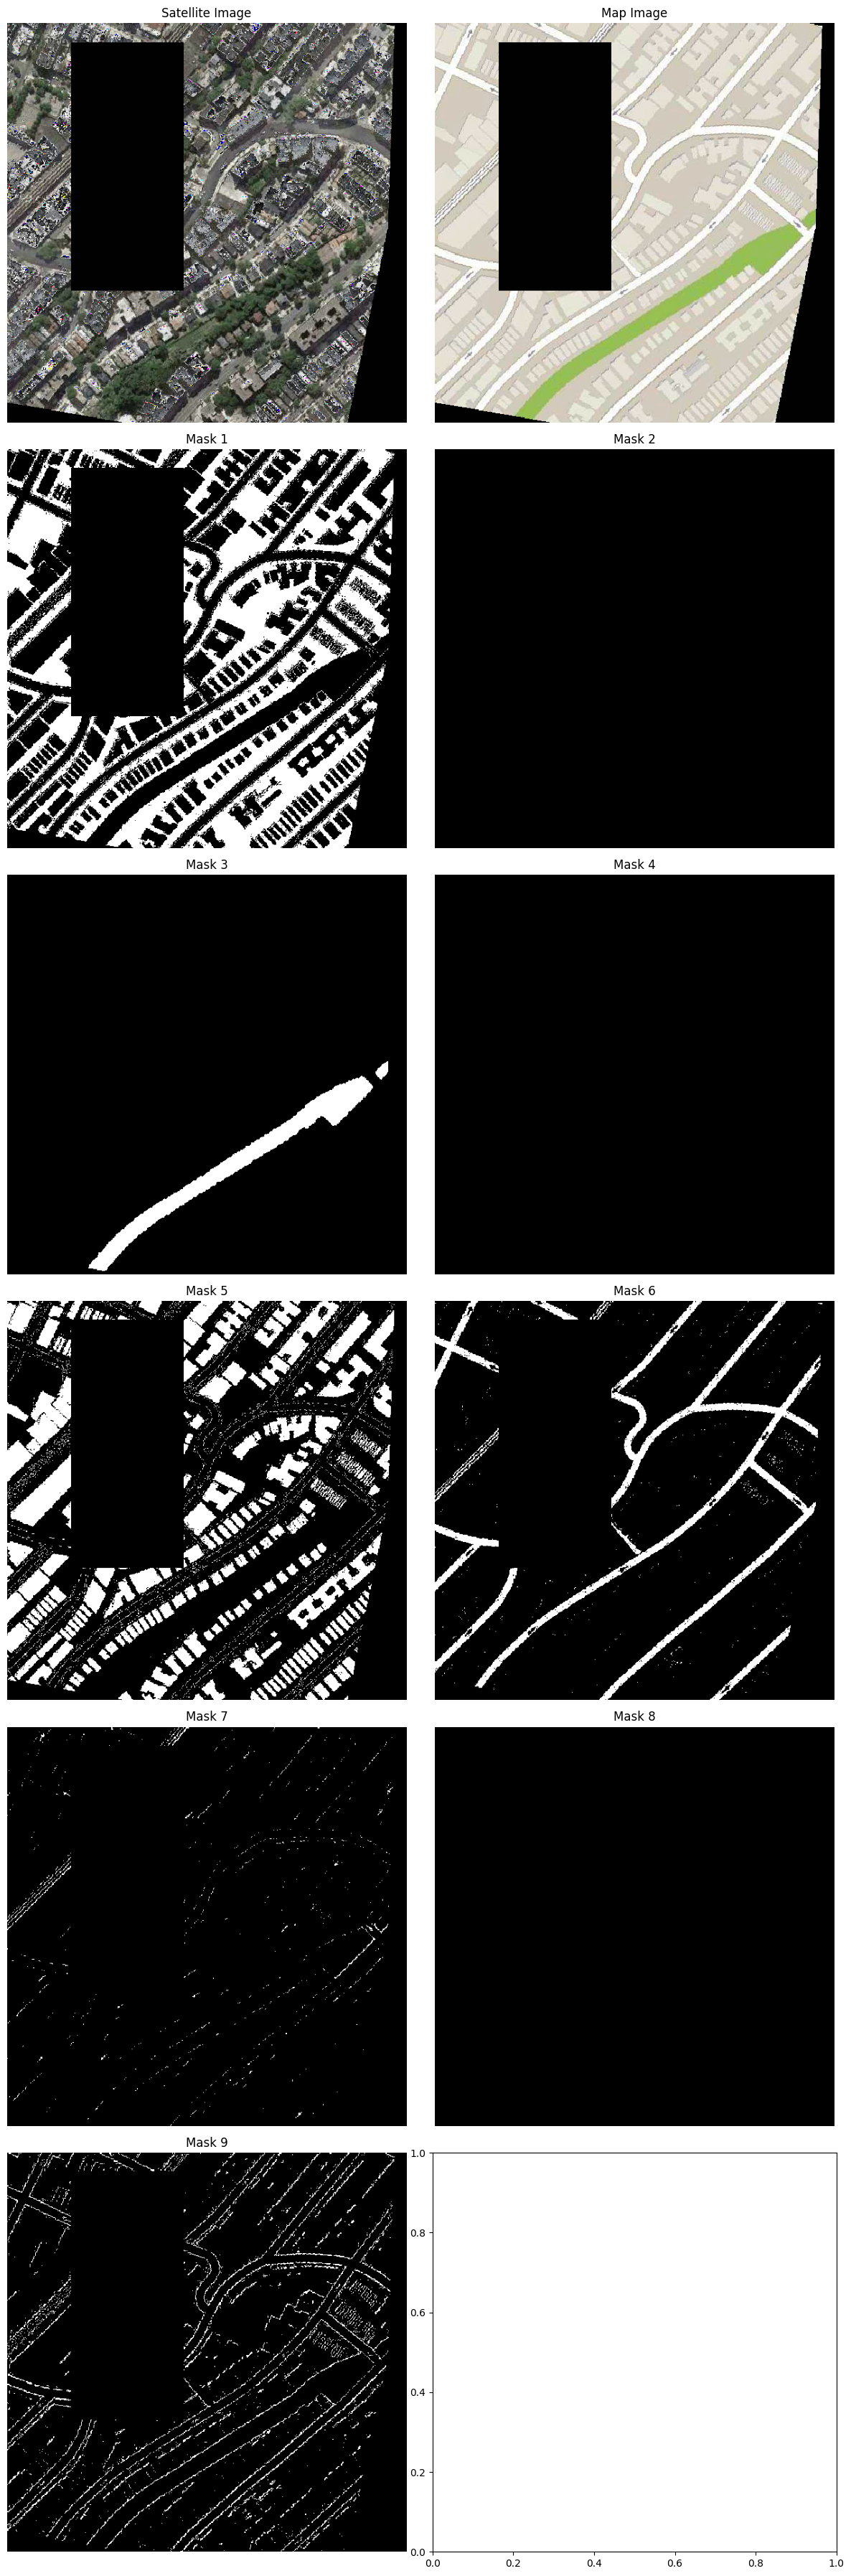

In [78]:
a = dataset[123]

In [5]:
a = [[222.54114006, 218.19486678, 209.03655732],
       [176.39517098, 207.36533546, 253.68176394],
       [242.3009299 , 240.07981674, 234.13577431],
       [245.81090326, 157.79299076,  38.5570436 ],
       [202.48862628, 222.39955981, 172.18012607],
       [232.15995471, 228.71470255, 222.00992067],
       [253.46324374, 253.25226467, 251.16236616],
       [247.36335589, 220.42228868, 136.22587754],
       [200.00481359, 205.19318739, 189.33936565],
       [230.09122322, 177.85173569,  78.10472596]]